In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import geopandas as gpd
import seaborn as sns


In [47]:
df = pd.read_csv('./geral/tabelas_concat.csv')

In [4]:
geo = pd.read_csv('./geral/olist_geolocation_dataset.csv')

In [50]:
df['review_creation_date'] = pd.to_datetime(df['review_creation_date'])
df['review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

In [18]:
NORTE = ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO']
NORDESTE = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
CENTROOESTE = ['DF', 'GO', 'MT', 'MS']
SUDESTE = ['ES', 'MG', 'SP', 'RJ']
SUL = ['PR', 'SC', 'RS']

def conversion_reg(n):
	if n in NORTE:
		return 'NORTE'
	elif n in NORDESTE:
		return 'NORDESTE'
	elif n in CENTROOESTE:
		return 'CENTROOESTE'
	elif n in SUDESTE:
		return 'SUDESTE'
	elif n in SUL:
		return 'SUL'
	else:
		return 'ERROR'

reg_customer = []
reg_seller = []
for regiao in df['customer_state']:
    reg_customer.append(conversion_reg(regiao))
for regiao in df['seller_state']:
    reg_seller.append(conversion_reg(regiao))
df['customer_region'] = reg_customer
df['seller_region'] = reg_seller
df.head(1)

,Unnamed: 0,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_region,seller_region
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,...,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,SUDESTE,SUDESTE


# Previsão de Demanda e Localização 

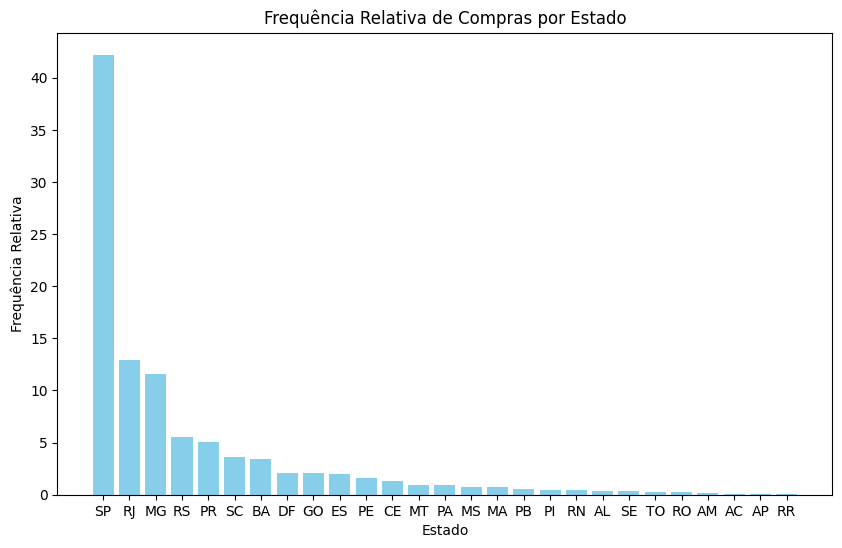

In [20]:
query = ''' SELECT customer_state, COUNT(product_id) AS total_products
            FROM df
            GROUP BY customer_state
            ORDER BY COUNT(product_id) DESC '''

result = sqldf(query, locals())


result['relative_frequency'] = result['total_products'] / result['total_products'].sum() *100

# Plotando o histograma de frequência relativa
plt.figure(figsize=(10, 6))
plt.bar(result['customer_state'], result['relative_frequency'], color='skyblue')
plt.title('Frequência Relativa de Compras por Estado')
plt.xlabel('Estado')
plt.ylabel('Frequência Relativa')
plt.show()

C:\Users\fabio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


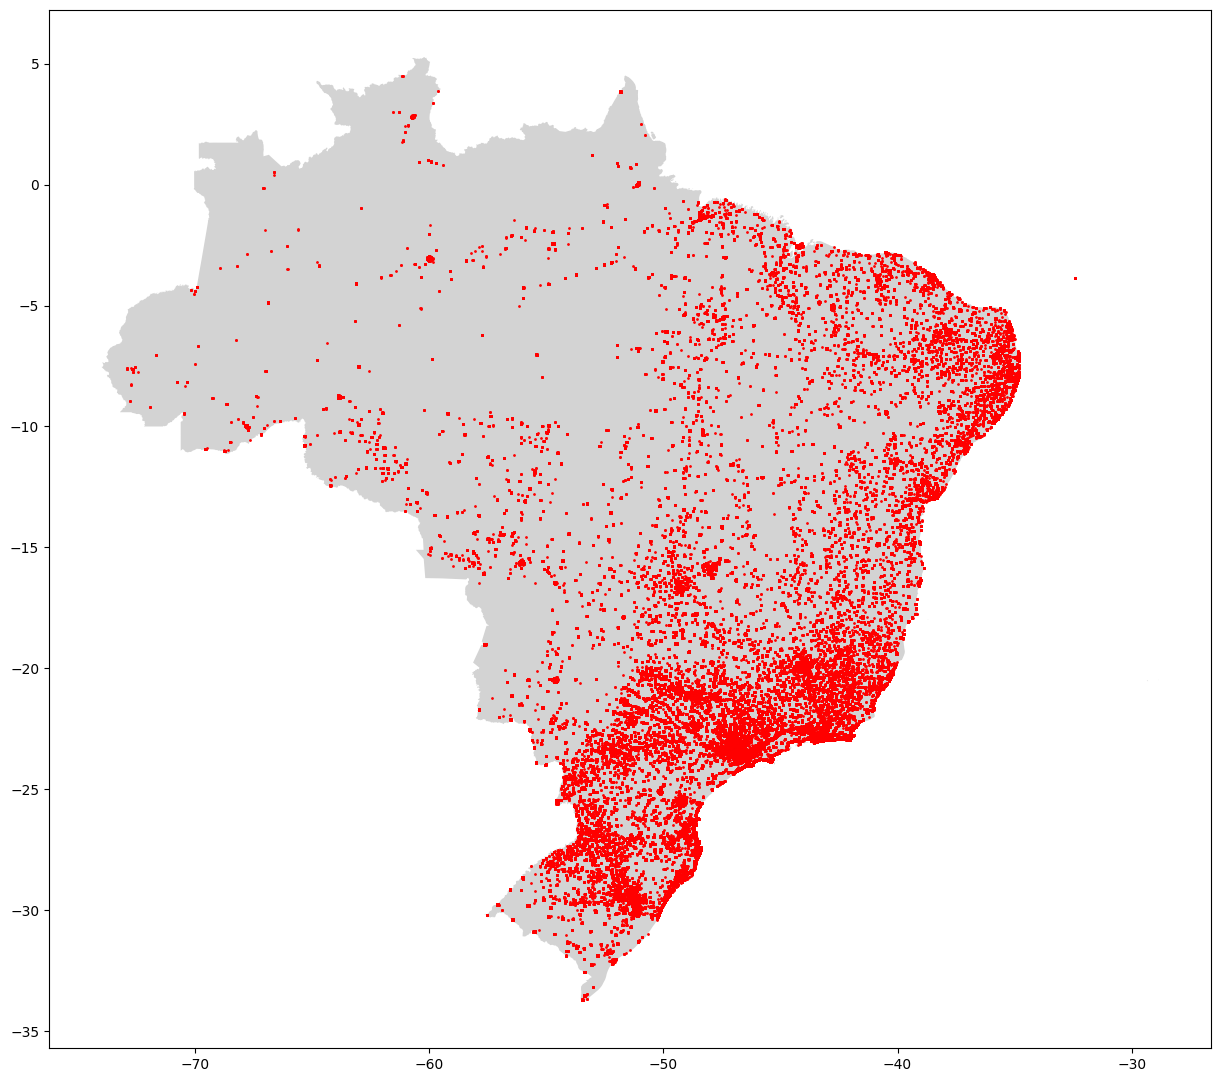

In [ ]:
gdf = gpd.read_file('./geral/BR_PAIS_2022.shp')

geo['geolocation_lat'] = geo['geolocation_lat'].astype(float)
geo['geolocation_lng'] = geo['geolocation_lng'].astype(float)

gdf_points = gpd.GeoDataFrame(
    geo, 
    geometry=gpd.points_from_xy(geo['geolocation_lng'], geo['geolocation_lat'])
)

gdf_points.crs = gdf.crs

gdf_points_within_brazil = gpd.sjoin(gdf_points, gdf, how="inner", op='within')

fig, ax = plt.subplots(figsize=(15, 15))

gdf.plot(ax=ax, color='lightgrey')

gdf_points_within_brazil.plot(ax=ax, markersize=1, color='red')

plt.show()

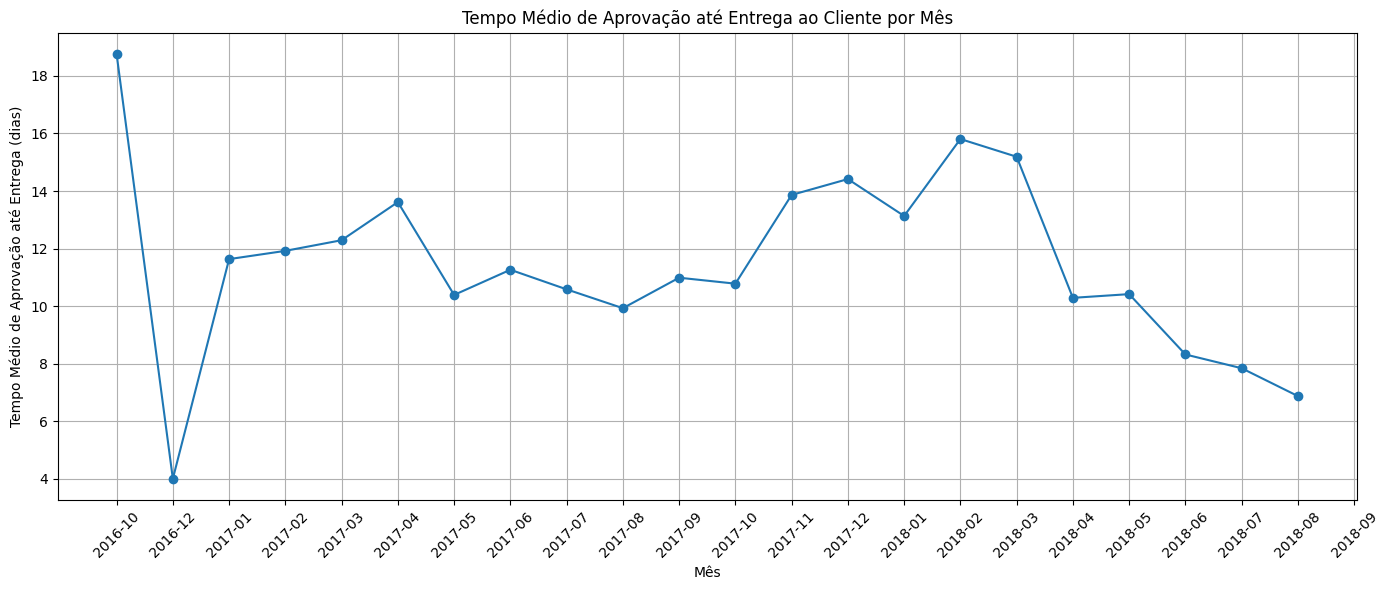

In [22]:
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['approval_to_delivery_days'] = (df['order_delivered_customer_date'] - df['order_approved_at']).dt.days


df['month'] = pd.to_datetime(df['order_approved_at']).dt.to_period('M')


monthly_avg_delay = df.groupby('month').agg({'approval_to_delivery_days': 'mean'}).reset_index()

# Plotagem
plt.figure(figsize=(14, 6))
plt.plot(monthly_avg_delay['month'].astype(str), monthly_avg_delay['approval_to_delivery_days'], marker='o')
plt.title('Tempo Médio de Aprovação até Entrega ao Cliente por Mês')
plt.xlabel('Mês')
plt.ylabel('Tempo Médio de Aprovação até Entrega (dias)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout() 
plt.show()


Tomada de decisão: Concentrar centros de distribuição nas regiões com maior frequência de pedidos

Métrica: Grafico Tempo Médio de Aprovação até Entrega ao Cliente por Mês

# Perfomance de categoria de produto

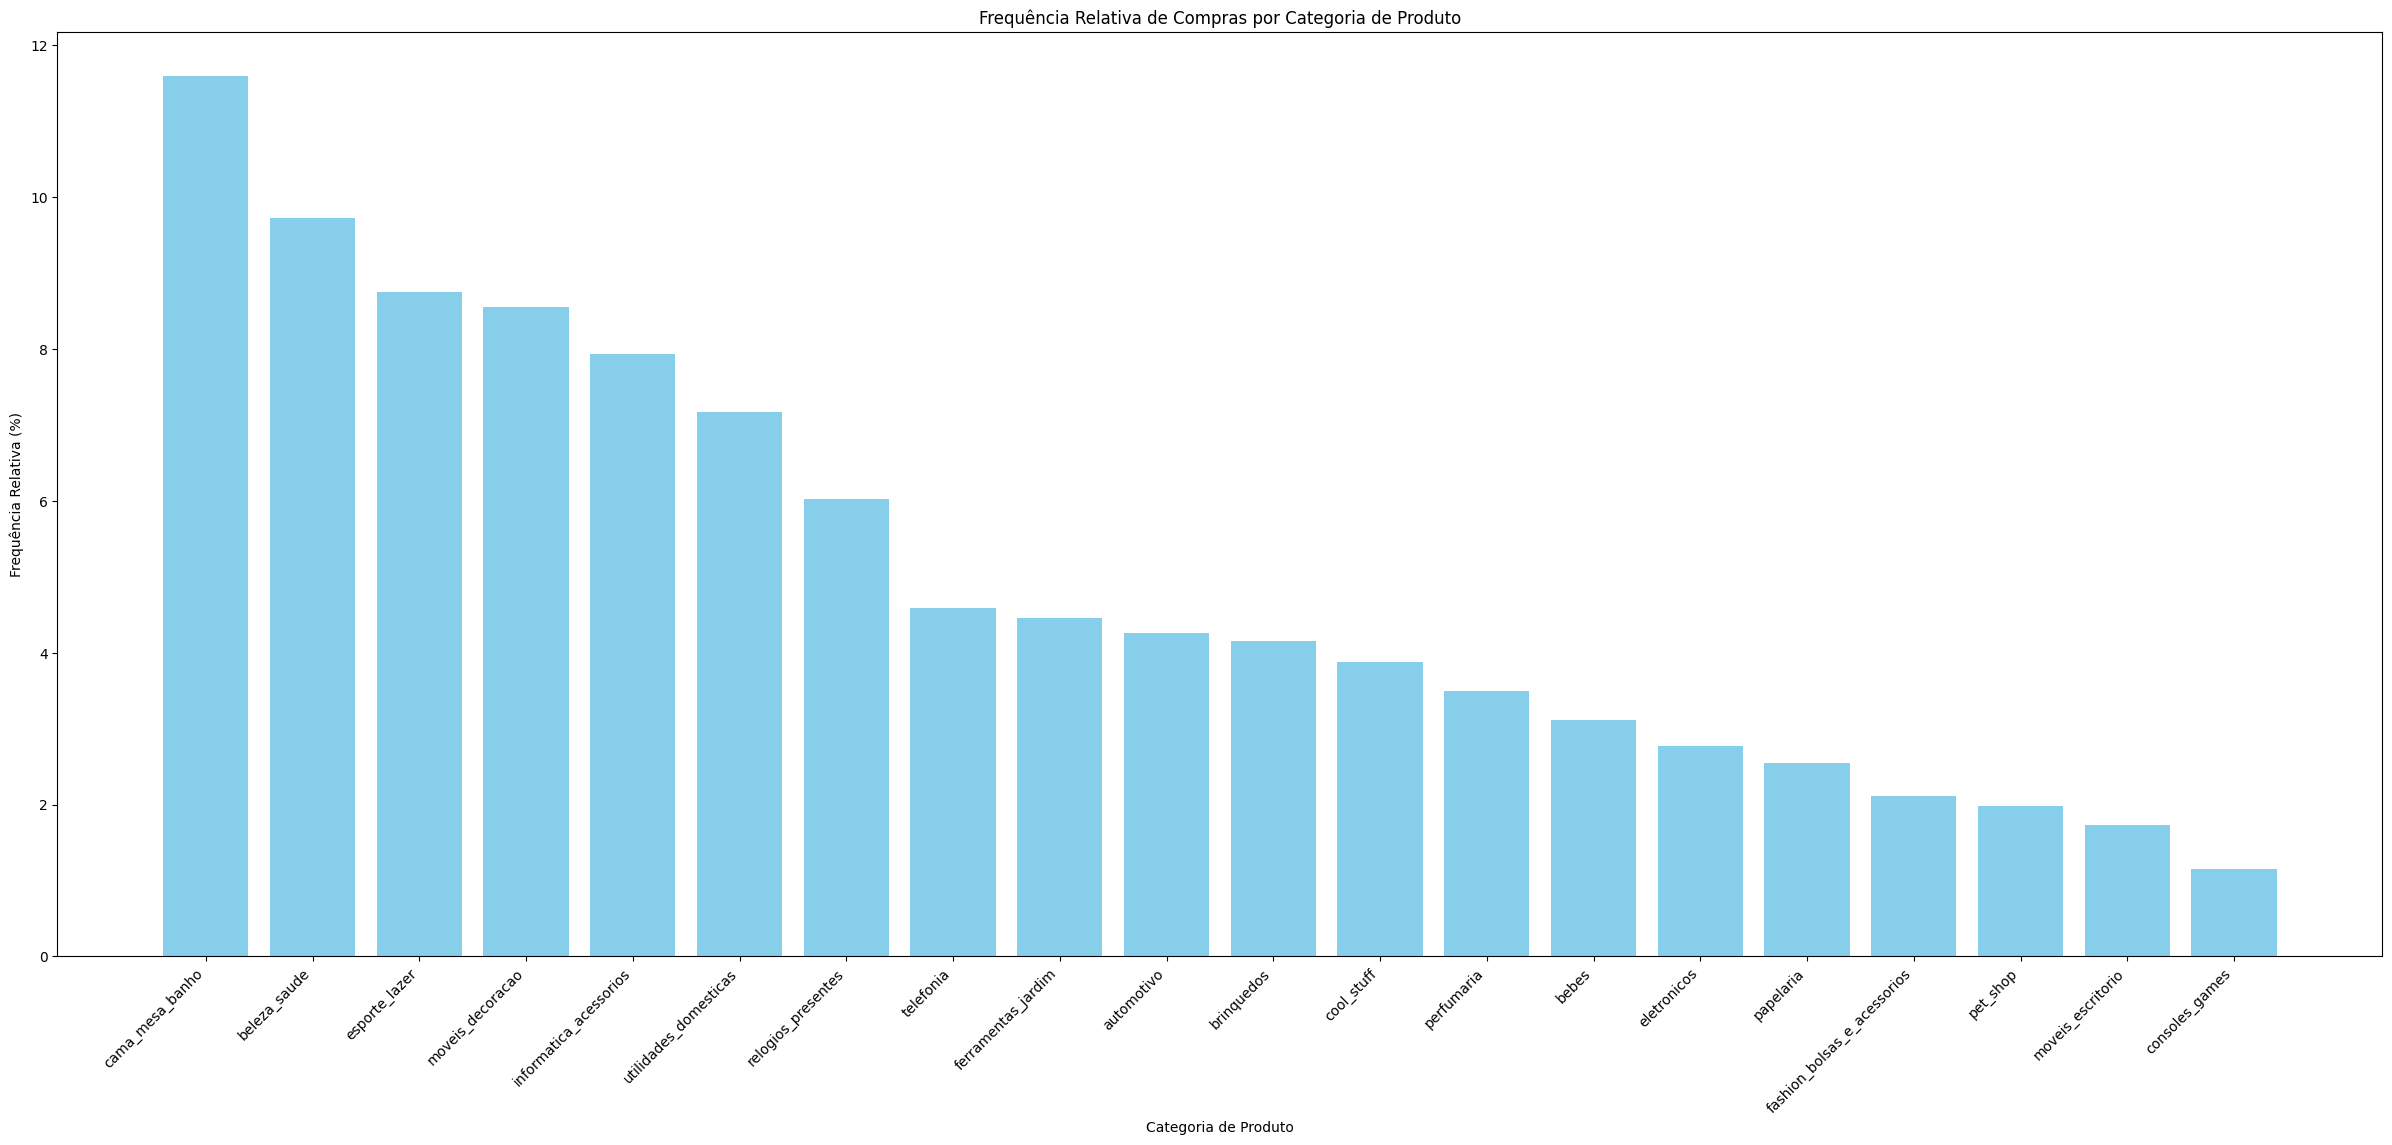

In [29]:
query = ''' SELECT product_category_name, COUNT(product_id) AS total_products
            FROM df
            WHERE product_category_name IS NOT NULL
            GROUP BY product_category_name
            ORDER BY COUNT(product_id) DESC
            LIMIT 20
        '''

# Executando a consulta SQL no DataFrame
result = sqldf(query, locals())

# Calculando a frequência relativa
result['relative_frequency'] = result['total_products'] / result['total_products'].sum() * 100

# Plotando o histograma de frequência relativa
plt.figure(figsize=(30, 12))
plt.bar(result['product_category_name'], result['relative_frequency'], color='skyblue')
plt.title('Frequência Relativa de Compras por Categoria de Produto')
plt.xlabel('Categoria de Produto')
plt.xticks(rotation=45, ha="right")  # Rotaciona os rótulos para melhor visualização
plt.ylabel('Frequência Relativa (%)')
plt.show()

In [30]:
result

,product_category_name,total_products,relative_frequency
0,cama_mesa_banho,11847,11.591069
1,beleza_saude,9944,9.729180
2,esporte_lazer,8942,8.748826
3,moveis_decoracao,8743,8.554125
4,informatica_acessorios,8105,7.929908
5,utilidades_domesticas,7331,7.172628
6,relogios_presentes,6161,6.027904
7,telefonia,4692,4.590639
8,ferramentas_jardim,4558,4.459534
9,automotivo,4356,4.261897


Metricas: Frequencia relativa dos produtos

Tomada de decisão: Estratégias de marketing em cima dos produtos com melhor perfomance

In [37]:
# Definindo faixas de preço
price_bins = [0, 100, 200, 300, 400, np.inf]
price_labels = ['0-100', '101-200', '201-300', '301-400', '>400']
df['price_range'] = pd.cut(df['payment_value'], bins=price_bins, labels=price_labels)

# Definindo faixas de valor do frete
freight_bins = [0, 20, 40, 60, 80, np.inf]
freight_labels = ['0-20', '21-40', '41-60', '61-80', '>80']
df['freight_range'] = pd.cut(df['freight_value'], bins=freight_bins, labels=freight_labels)

# Tendências e Variações Sazonais ou Identificação de Problemas Operacionais

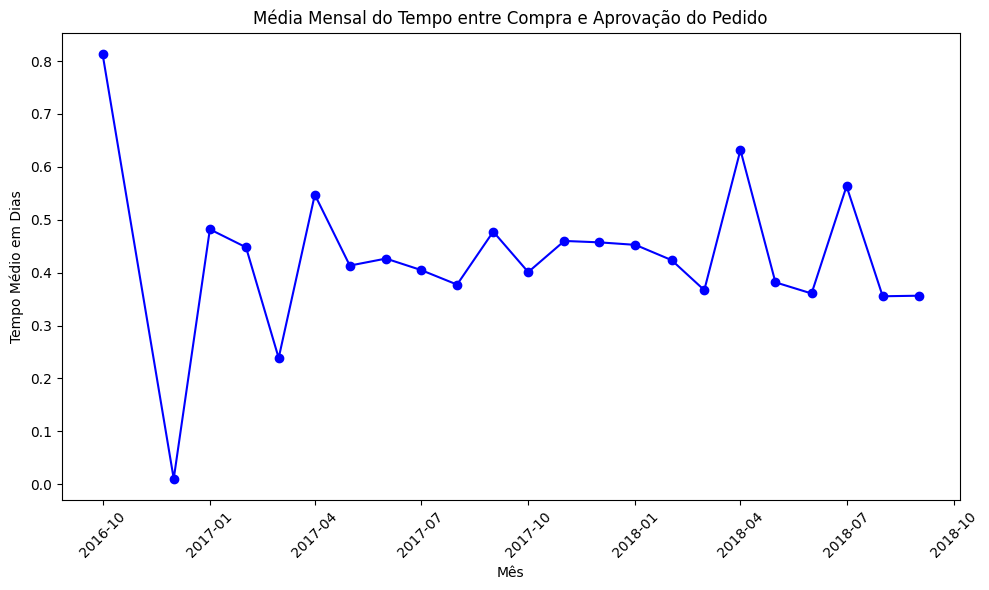

In [51]:
df['time_difference'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / (60 * 60 * 24)

# Adicionando uma coluna de mês e ano para agrupamento
df['month_year'] = df['order_purchase_timestamp'].dt.to_period('M')
df = df.loc[(df['month_year'] != '2016-09')]

# Calculando a média de tempo de diferença por mês
monthly_avg = df.groupby('month_year')['time_difference'].mean().reset_index()

# Convertendo 'month_year' de volta para datetime para plotar
monthly_avg['month_year'] = monthly_avg['month_year'].dt.to_timestamp()

# Plotando
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg['month_year'], monthly_avg['time_difference'], marker='o', linestyle='-', color='blue')
plt.title('Média Mensal do Tempo entre Compra e Aprovação do Pedido')
plt.xlabel('Mês')
plt.ylabel('Tempo Médio em Dias')
plt.xticks(rotation=45)
plt.tight_layout() # Ajusta automaticamente os parâmetros do subplot para que o subplot se encaixe na área do gráfico
plt.show()

Métrica: Média mensal do Tempo entre Compra e Aprovação do Pedido

Tomada de decisão:  aumentos significativos em certos meses podem indicar períodos de alta demanda que pode levar a preparação de estoque como vemos no caso do mes de abril. Ou identificar possiveis problemas operacionais a serem resolvidos

# Erros médios das estimativas de chegada (Excluindo os dados nulos das entregas nao registradas)

In [57]:
estimativas = df[['order_delivered_customer_date', 'order_estimated_delivery_date', 'review_score']].dropna()
estimativas

,order_delivered_customer_date,order_estimated_delivery_date,review_score
0,2017-05-25 10:35:35,2017-06-05 00:00:00,4
1,2017-11-28 00:09:50,2017-12-19 00:00:00,1
2,2017-11-28 00:09:50,2017-12-19 00:00:00,1
3,2017-05-26 09:54:04,2017-06-12 00:00:00,3
4,2018-02-28 21:09:00,2018-03-22 00:00:00,4
...,...,...,...
117322,2018-07-27 11:54:15,2018-08-14 00:00:00,5
117324,2018-08-13 23:16:46,2018-08-27 00:00:00,5
117326,2018-08-28 18:16:44,2018-09-10 00:00:00,5
117327,2017-12-19 19:37:33,2017-12-12 00:00:00,1


In [58]:
estimativas['order_estimated_delivery_date'] = pd.to_datetime(estimativas['order_estimated_delivery_date'])
estimativas['order_delivered_customer_date'] = pd.to_datetime(estimativas['order_delivered_customer_date'])

In [59]:
estimativas['delivery_diff'] = (estimativas['order_delivered_customer_date'] - estimativas['order_estimated_delivery_date']).dt.days

# Calculando o Erro Absoluto Médio
mae = mean_absolute_error(estimativas['delivery_diff'], np.zeros(len(estimativas)))
print(f"MAE: {round(mae)} dias")

# Calculando a Raiz do Erro Quadrático Médio - Para dar maior peso a erros maiores
rmse = np.sqrt(mean_squared_error(estimativas['delivery_diff'], np.zeros(len(estimativas))))
print(f"RMSE: {int(round(rmse))} dias")


MAE: 13 dias
RMSE: 16 dias


In [155]:
average_diff = estimativas['delivery_diff'].mean()
print(f"Média de diferença de dias: {average_diff}")

if average_diff > 0:
    print("Em média, as entregas são mais lentas do que o estimado.")
elif average_diff < 0:
    print("Em média, as entregas são mais rápidas do que o estimado.")
else:
    print("Em média, as entregas correspondem exatamente às estimativas.")

Média de diferença de dias: -12.08457399571645
Em média, as entregas são mais rápidas do que o estimado.


In [140]:
# Definir o intervalo de tolerância (em dias)
tolerance = 2  # Por exemplo, até 2 dias antes ou depois da data estimada

# Calcular se cada entrega está no prazo
estimativas['on_time'] = estimativas['delivery_diff'].abs() <= tolerance

# Calcular a porcentagem de entregas no prazo
fa = (estimativas['on_time'].sum() / len(estimativas)) * 100

print(f"Índice de Precisão de Previsão (FA): {fa:.2f}%")

Índice de Precisão de Previsão (FA): 5.66%


# Demoras do pedido baseado na estimativa afeta a avaliação

In [60]:
avaliacao = estimativas
avaliacao

,order_delivered_customer_date,order_estimated_delivery_date,review_score,delivery_diff
0,2017-05-25 10:35:35,2017-06-05,4,-11
1,2017-11-28 00:09:50,2017-12-19,1,-21
2,2017-11-28 00:09:50,2017-12-19,1,-21
3,2017-05-26 09:54:04,2017-06-12,3,-17
4,2018-02-28 21:09:00,2018-03-22,4,-22
...,...,...,...,...
117322,2018-07-27 11:54:15,2018-08-14,5,-18
117324,2018-08-13 23:16:46,2018-08-27,5,-14
117326,2018-08-28 18:16:44,2018-09-10,5,-13
117327,2017-12-19 19:37:33,2017-12-12,1,7


In [62]:
#Avaliações e estimativas
query = ''' SELECT delivery_diff, review_score
            FROM avaliacao
            ORDER BY delivery_diff DESC '''

result = sqldf(query, locals())
result

,delivery_diff,review_score
0,188,2
1,175,1
2,167,1
3,166,1
4,165,1
...,...,...
114853,-124,5
114854,-135,3
114855,-140,5
114856,-147,5


In [ ]:
# Usando a probabilidade experimental para definir o valor de tendencia da depreciação da avaliação do produto por conta do atraso

filtro = result['delivery_diff'] >= 0
filtro2 = result['delivery_diff'] <= 0

maior = result[filtro][['delivery_diff', 'review_score']]
menor = result[filtro2][['delivery_diff', 'review_score']]

linhas_aleatorias_maior = maior.sample(n=4000)
linhas_aleatorias_menor = menor.sample(n=4000)

print(linhas_aleatorias_maior['review_score'].sum())
print(linhas_aleatorias_menor['review_score'].sum())

diferenca_percentual = ((linhas_aleatorias_maior['review_score'].sum() - linhas_aleatorias_menor['review_score'].sum()) / linhas_aleatorias_menor['review_score'].sum()) * 100
diferenca_percentual

10241
16767


-38.921691417665656

Tomada de decisão: Melhorar as estimativas de chegada, Avaliações dos clientes em relação ao produto tendem a ser 38% menores por causa do tempo de atraso da mercadoria em realção a estimativa de chegada

Médias de erro absoluto